# House Rent Prediction

The project aims to explore and analyse the housing rental market in India, where housing options range from palaces to tiny places. The Human Rights Measurement Initiative has found that India is doing 60.9% of what should be possible at its level of income for the right to housing. The dataset contains information on over 4700+ houses/apartments/flats available for rent with various parameters such as BHK, rent, size, no. of floors, area type, area locality, city, furnishing status, type of tenant preferred, no. of bathrooms, and point of contact. The project will involve data exploration, cleaning, engineering, and creating firstly the base models, and then hybrid model to gain insights into the rental market and make predictions on rental prices.

## Initial Steps

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive

drive.mount('/content/drive')

 #Move this file to different folder as expected by kaggle python library.
 
! mkdir ~/.kaggle

# It is on my gdrive I am copying like this
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

# If it is in your working folder then your can copy like this
#! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [3]:
!kaggle d download iamsouravbanerjee/house-rent-prediction-dataset

!unzip /content/house-rent-prediction-dataset.zip

  0% 0.00/82.4k [00:00<?, ?B/s]
100% 82.4k/82.4k [00:00<00:00, 21.2MB/s]
Archive:  /content/house-rent-prediction-dataset.zip
  inflating: Dataset Glossary.txt    
  inflating: House_Rent_Dataset.csv  


In [ ]:
# Download the dataset for competition usign kaggle API
# !kaggle datasets download -d iamsouravbanerjee/house-rent-prediction-dataset # used in jupyter

In [6]:
# Import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# data preparing and engineering
import zipfile # To extract Kaggle data
import re # For data engineering
from scipy.stats import ttest_ind # For t-test
from sklearn.model_selection import train_test_split # For splitting data into training and test set

# pipeline elements
from sklearn.compose import ColumnTransformer # For transformation dataframe in pipeline
from sklearn.preprocessing import FunctionTransformer # For transforming dataframe before training
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler # Encoder and scalers
from sklearn.feature_selection import RFE # RFE for feature seelction

# pipeline related libraries
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion # For pipeline and creating hybrid
from sklearn.model_selection import GridSearchCV # For cross-valdiation 

# metrics
from scipy.stats import spearmanr # For calculation correlation
from sklearn.metrics import mean_squared_error, r2_score # Score metrics

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor

In [7]:
# Set styles for plots and change display setting for the matplotlib
sns.set_style('whitegrid')
plt.style.use('ggplot')
%matplotlib inline

In [8]:
# Read the .csv files
df = pd.read_csv('House_Rent_Dataset.csv')

## Data Exploration

In [9]:
# Show the 10 first rows
df.head(10)

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner
5,2022-04-29,2,7000,600,Ground out of 1,Super Area,Thakurpukur,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
6,2022-06-21,2,10000,700,Ground out of 4,Super Area,Malancha,Kolkata,Unfurnished,Bachelors,2,Contact Agent
7,2022-06-21,1,5000,250,1 out of 2,Super Area,Malancha,Kolkata,Unfurnished,Bachelors,1,Contact Agent
8,2022-06-07,2,26000,800,1 out of 2,Carpet Area,"Palm Avenue Kolkata, Ballygunge",Kolkata,Unfurnished,Bachelors,2,Contact Agent
9,2022-06-20,2,10000,1000,1 out of 3,Carpet Area,Natunhat,Kolkata,Semi-Furnished,Bachelors/Family,2,Contact Owner


In [10]:
# Show basic info about the database
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [11]:
# Change the type of column "Posted On" to datetpye
df['Posted On'] = pd.to_datetime(df['Posted On'])

In [12]:
# Check basic statistics for numerical columns
df.describe()

,BHK,Rent,Size,Bathroom
count,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2.083860,3.499345e+04,967.490729,1.965866
std,0.832256,7.810641e+04,634.202328,0.884532
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


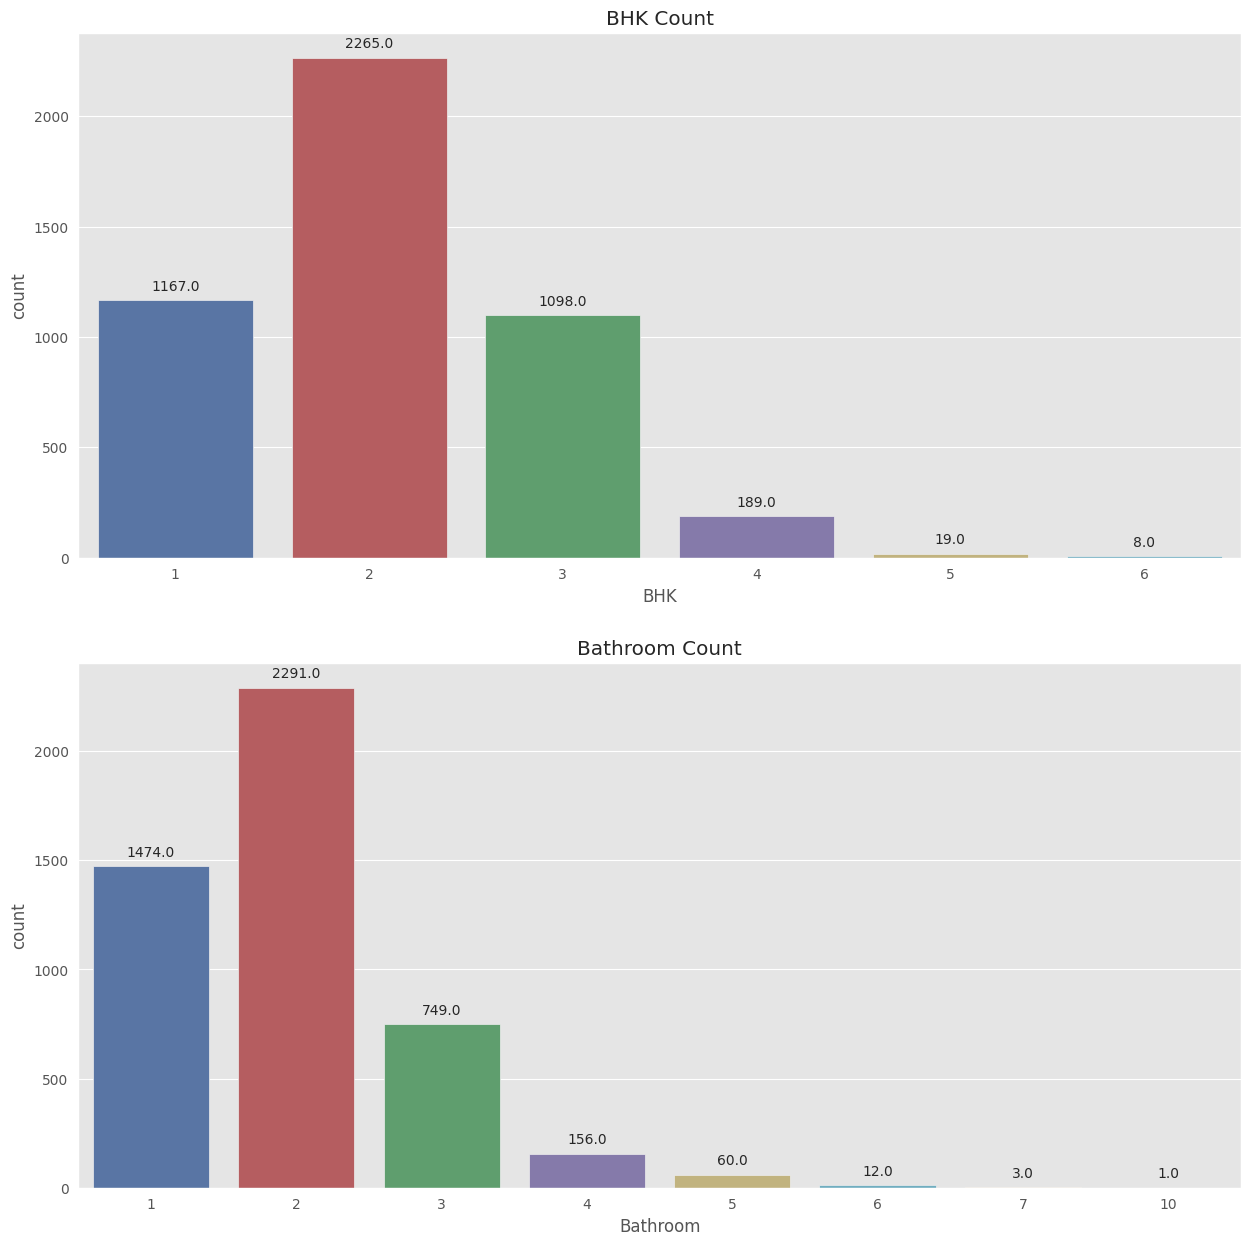

In [13]:
# Create a countplot for BHK and Bathroom

# define a custom colour palette
colors = ['#4C72B0', '#C44E52', '#55A868', '#8172B2', '#CCB974', '#64B5CD', '#FFE5B4', '#FFE5B9']

# create subplots for few columns
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

# create count plots for few columns
sns.countplot(x='BHK', data=df, palette=colors, ax=axs[0])
sns.countplot(x='Bathroom', data=df, palette=colors, ax=axs[1])

# set the plot titles
axs[0].set_title('BHK Count')
axs[1].set_title('Bathroom Count')

# annotate each bar with count labels
for ax in axs:
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [20]:
# Check the instance with 10 bathrooms
df[df['Bathroom'] == 10]

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact


In [ ]:
# Delete the suspicious row / outlier 
df.drop(4185, axis=0, inplace=True)

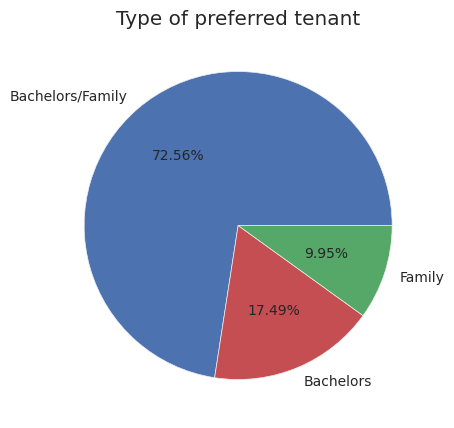

In [18]:
# Create a pie chart for a preferred type of tenant
plt.figure(figsize=(5,5))
plt.title('Type of preferred tenant')
plt.pie(df['Tenant Preferred'].value_counts(), labels=df['Tenant Preferred'].unique(), 
        autopct='%1.2f%%', colors=colors)
plt.show()

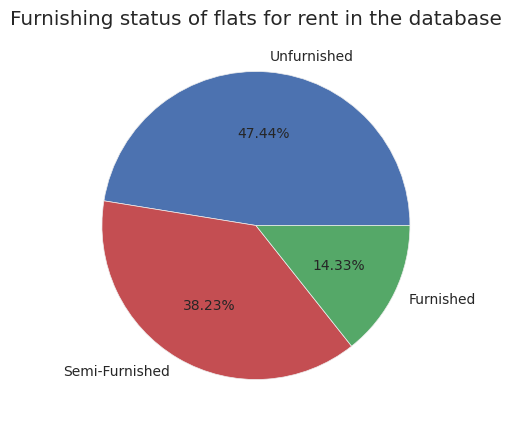

In [22]:
# Create a pie chart for furnishing status of flats
plt.figure(figsize=(5,5))
plt.title('Furnishing status of flats for rent in the database')
plt.pie(df['Furnishing Status'].value_counts(), labels=df['Furnishing Status'].unique(), 
        autopct='%1.2f%%', colors=colors)
plt.show()

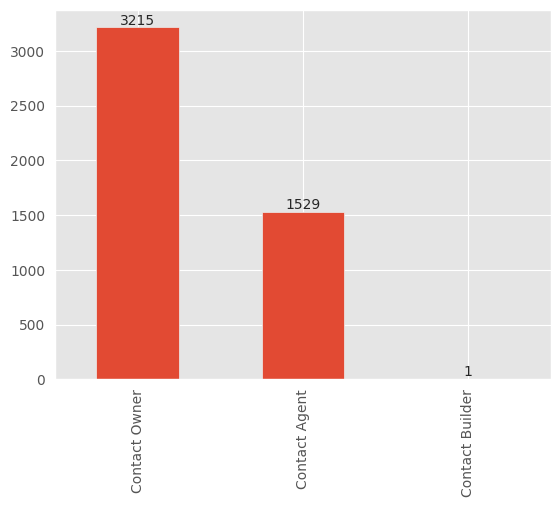

In [23]:
# Count plot of "Point of Contact" of each offer

# create the bar plot
ax = df['Point of Contact'].value_counts().plot(kind='bar')

# add annotations to the bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10)

# show the plot
plt.show()

In [24]:
# Create a dictionary to map the string values to numerical values
map_pc = {
    'Contact Owner': 1,
    'Contact Agent': 2,
    'Contact Builder': 3,
}

# create a copy of dataframe
df_corr_rent_to_pc = df.copy()

# replace the string values with numerical values
df_corr_rent_to_pc['Point of Contact'] = df_corr_rent_to_pc['Point of Contact'].replace(map_pc)

# calculate the correlation coefficient
corr_rent_to_pc = df_corr_rent_to_pc['Rent'].corr(df_corr_rent_to_pc['Point of Contact'])

# print the correlation coefficient
print('Correlation coefficient:', corr_rent_to_pc)

Correlation coefficient: 0.33945005661712896


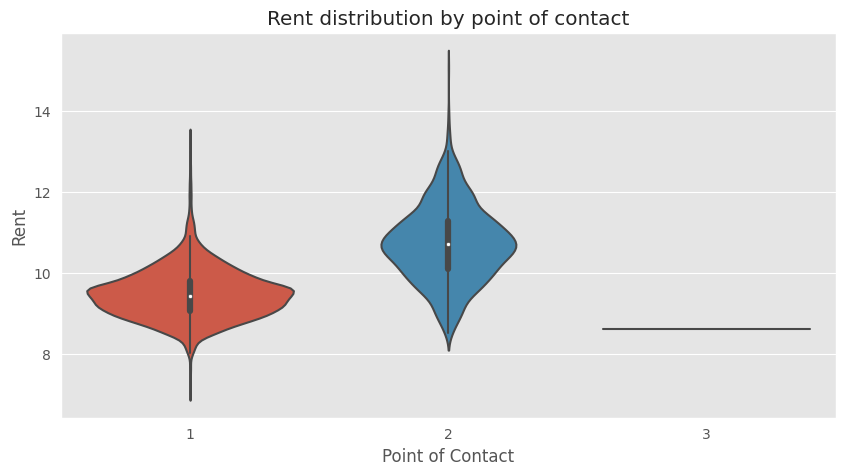

In [26]:
# Create log values for rent
log_rent = np.log(df_corr_rent_to_pc.Rent)

# create a violin plot
plt.figure(figsize=(10,5))
sns.violinplot(x='Point of Contact', y=log_rent, data=df_corr_rent_to_pc)

# set the plot title and labels
plt.title('Rent distribution by point of contact')
plt.xlabel('Point of Contact')
plt.ylabel('Rent')

# show the plot
plt.show()

In [27]:
# Use boolean indexing to filter the DataFrame to find the only one instance of "Point of Contact"
df[df['Point of Contact'] == 'Contact Builder']

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
4061,2022-06-18,1,5500,400,1 out of 2,Super Area,"Ramanthapur, NH 2 2",Hyderabad,Unfurnished,Bachelors/Family,1,Contact Builder


In [28]:
# Get rid of a row that may affect the performance of the model
df.drop(4061, axis=0, inplace=True)

In [29]:
# Separate the rent values for each group
rent1 = df_corr_rent_to_pc[df_corr_rent_to_pc['Point of Contact'] == 1]['Rent']
rent2 = df_corr_rent_to_pc[df_corr_rent_to_pc['Point of Contact'] == 2]['Rent']

# perform the t-test
t_statistic, p_value = ttest_ind(rent1, rent2)

# print the results
print('t-statistic:', t_statistic)
print('p-value:', p_value)

# check if the p-value is less than the significance level (alpha)
alpha = 0.05
if p_value < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')
    print('The diffrence in the means of Rent for each group is significant')

t-statistic: -24.91299681376779
p-value: 7.520241228099176e-129
Reject the null hypothesis


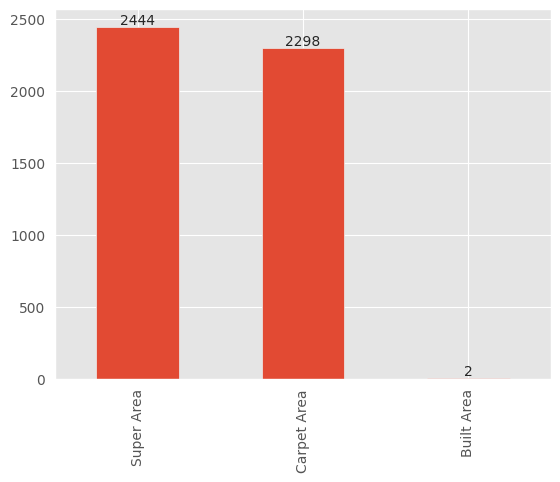

In [30]:
# Count plot for "Area Type"

# create the bar plot
ax = df['Area Type'].value_counts().plot(kind='bar')

# add annotations to the bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fontsize=10)

# show the plot
plt.show()

In [31]:
# Create a dictionary to map the string values to numerical values
map_at = {
    'Super Area': 1,
    'Carpet Area': 2,
    'Built Area': 3,
}

# create a copy of dataframe
df_corr_rent_to_at = df.copy()

# replace the string values with numerical values
df_corr_rent_to_at['Area Type'] = df_corr_rent_to_at['Area Type'].replace(map_at)

# calculate the correlation coefficient
corr_rent_to_at = df_corr_rent_to_at['Rent'].corr(df_corr_rent_to_at['Area Type'])

# print the correlation coefficient
print('Correlation coefficient:', corr_rent_to_at)

Correlation coefficient: 0.2153682362731037


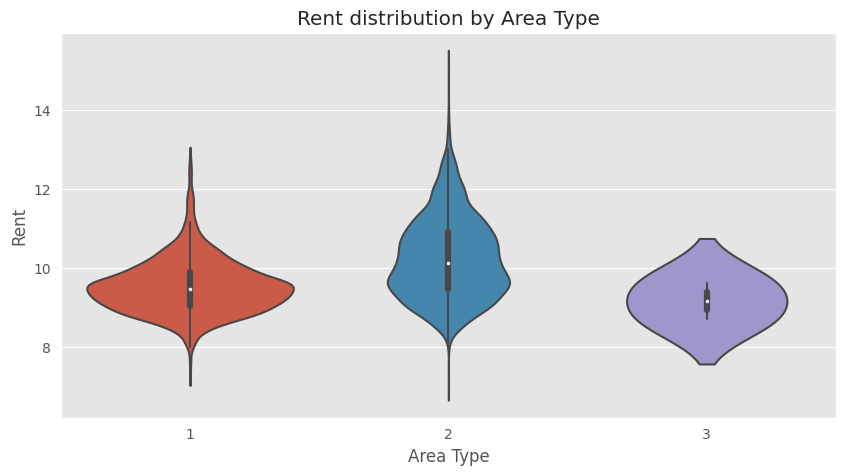

In [32]:
# Create log values for rent
log_rent = np.log(df_corr_rent_to_at.Rent)

# create a violin plot
plt.figure(figsize=(10,5))
sns.violinplot(x='Area Type', y=log_rent, data=df_corr_rent_to_at)

# set the plot title and labels
plt.title('Rent distribution by Area Type')
plt.xlabel('Area Type')
plt.ylabel('Rent')

# show the plot
plt.show()

In [33]:
# Use boolean indexing to filter the DataFrame to find records with "Built Area"
df[df['Area Type'] == 'Built Area']

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
3079,2022-06-21,2,15000,1000,1 out of 2,Built Area,"Chromepet, GST Road",Chennai,Furnished,Bachelors/Family,2,Contact Owner
3966,2022-06-17,1,6000,500,5 out of 5,Built Area,Seri Lingampally,Hyderabad,Unfurnished,Bachelors/Family,1,Contact Owner


In [34]:
# Get rid of suspicious row that may affect the performance of the model
df.drop(3079, axis=0, inplace=True)
df.drop(3966, axis=0, inplace=True)

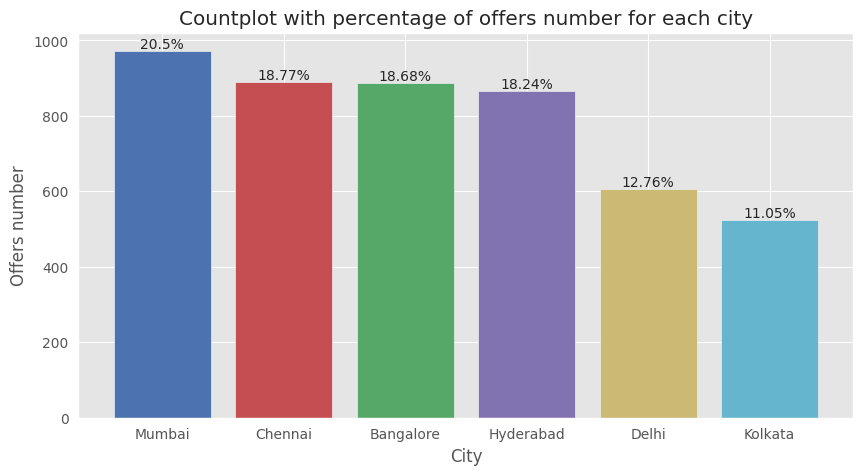

In [36]:
# Create count plots for offers by city

# calculate percentage and count number for each category
city_counts_p = (df['City'].value_counts(normalize=True))*100
city_counts = df['City'].value_counts()

# create a bar plot
plt.figure(figsize=(10,5))
plt.bar(city_counts.index, city_counts.values, color=colors)

# annotate bars with count number
for i, count in enumerate(city_counts_p):
    plt.annotate(f'{round(count,2)}%', xy=(i, city_counts[i]), ha='center', va='bottom')

# annotate bars with titles
plt.xlabel('City')
plt.ylabel('Offers number')
plt.title('Countplot with percentage of offers number for each city')
plt.show()

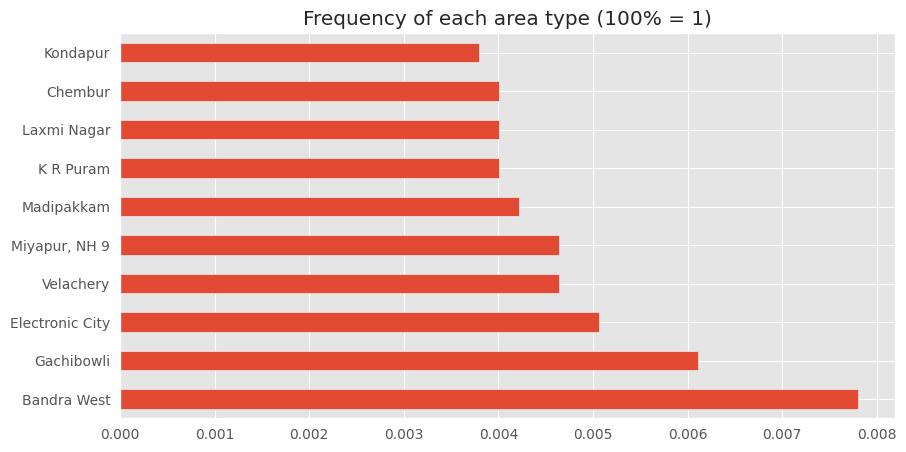

In [38]:
# Create a frequency plot showing popularity of each area in database offers
df['Area Locality'].value_counts(normalize=True)[:10].plot(kind='barh', figsize=(10,5),
                                                           title='Frequency of each area type (100% = 1)')
plt.show()

In [39]:
# Deleting the feautre of "Area Locality" due to the very low amount of instances per class
df.drop('Area Locality', inplace=True, axis=1)

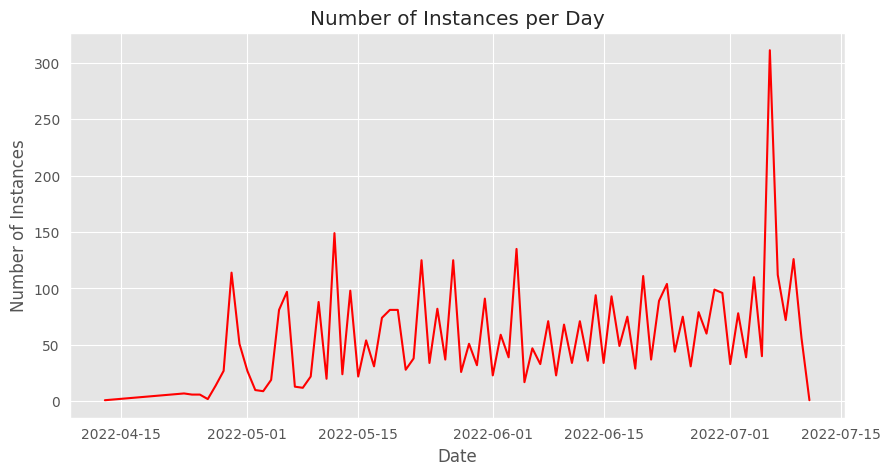

In [40]:
# Group by date and count the number of instances for each day
df_daily = df.groupby('Posted On').size().reset_index(name='num_instances')

# plot the result using Matplotlib
plt.figure(figsize=(10,5))
plt.plot(df_daily['Posted On'], df_daily['num_instances'], 'r-')

# set the x and y axis label
plt.xlabel('Date')
plt.ylabel('Number of Instances')

# set the title
plt.title('Number of Instances per Day')

# add grid for better readability
plt.grid('True')

# show the plot
plt.show()

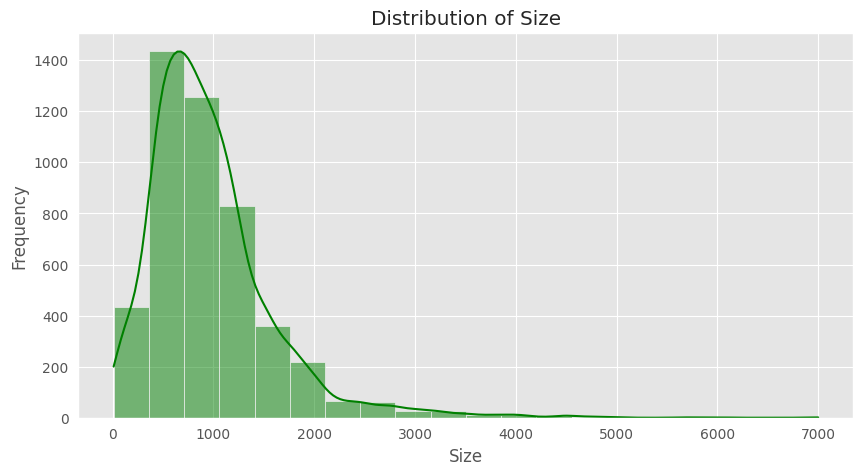

In [41]:
# Extract the "Size" column and sort it in ascending order
size_sorted = df['Size'].sort_values()

# plot the distribution of sizes
plt.figure(figsize=(10,5))
sns.histplot(size_sorted, bins=20, color='green', kde=True)

# set the x and y axis label
plt.xlabel('Size')
plt.ylabel('Frequency')

# set the title
plt.title('Distribution of Size')

# show the plot
plt.show()

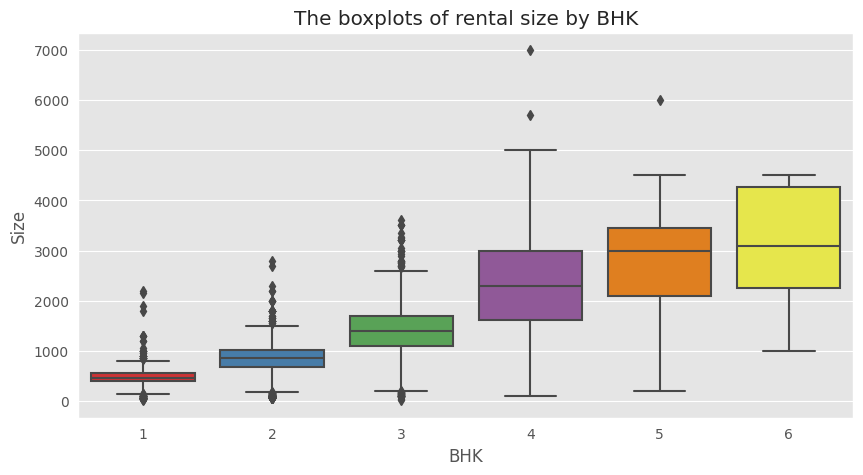

In [42]:
# Plot the size against BHK through boxplots
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('The boxplots of rental size by BHK')
sns.boxplot(data=df, x='BHK', y='Size', palette='Set1', ax=ax)
plt.show()

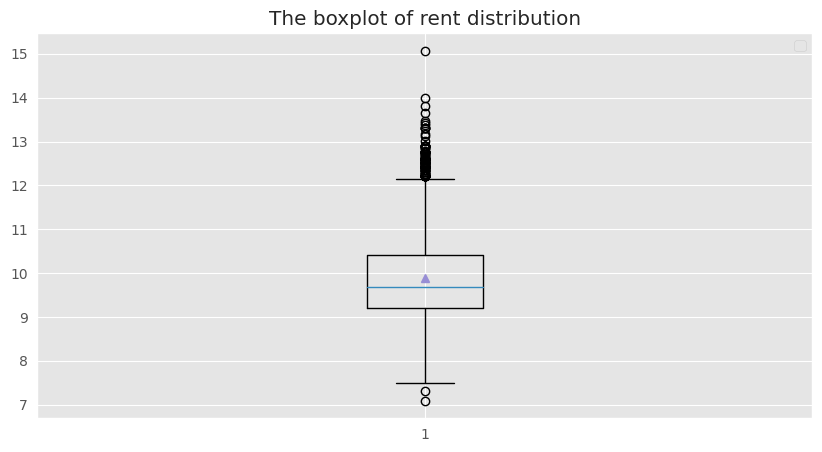

In [43]:
# Boxplot of rent
plt.figure(figsize=(10,5))
plt.title('The boxplot of rent distribution')
plt.legend()
plt.boxplot(np.log(df.Rent), showmeans=True) #  log transformation is needed due to many outliers
plt.show()

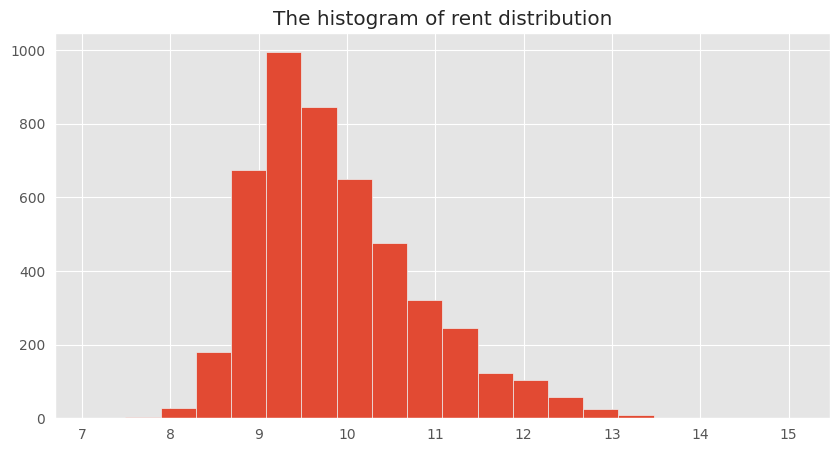

In [44]:
# Histogram of rent distribution
plt.figure(figsize=(10,5))
plt.title('The histogram of rent distribution')
plt.hist(np.log(df.Rent), bins=20) # log transformation is needed due to many outliers
plt.show()

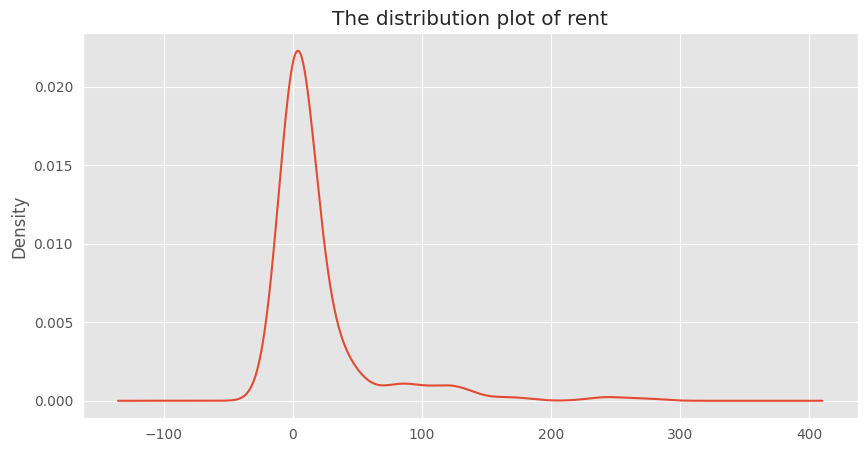

In [45]:
# Distribution plot of rent
df.Rent.value_counts().plot(kind='kde', figsize=(10,5), title='The distribution plot of rent')
plt.show()

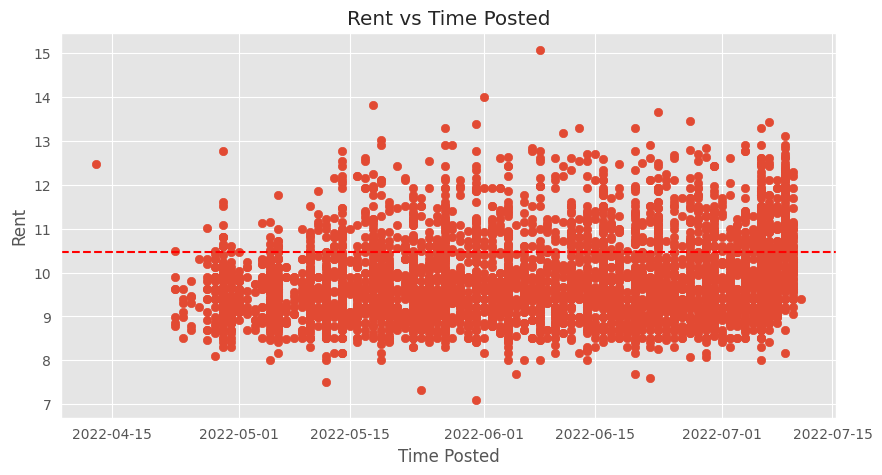

In [46]:
# Create a scatter plot of rent vs time posted
plt.figure(figsize=(10,5))
plt.scatter(df['Posted On'], np.log(df['Rent']))

# add a line indicating a mean
plt.axhline(np.log(df['Rent'].mean()), color='r', linestyle='--')

# set the x-axis label and title
plt.xlabel('Time Posted')
plt.ylabel('Rent')
plt.title('Rent vs Time Posted')

# display the plot
plt.show()

In [47]:
# Show top ten highest rent values
df.Rent.sort_values(ascending=False)[:10]

1837    3500000
1001    1200000
827     1000000
1329     850000
1459     700000
1484     680000
1319     650000
726      600000
1384     600000
3656     600000
Name: Rent, dtype: int64

In [48]:
# Show top ten lowest rent values
df.Rent.sort_values(ascending=True)[:10]

4076    1200
285     1500
471     1800
2475    2000
506     2200
146     2200
3068    3000
330     3000
4220    3000
221     3000
Name: Rent, dtype: int64

In [49]:
# Display rows with rent values under 2000 
df[df['Rent'] < 2000]

,Posted On,BHK,Rent,Size,Floor,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
285,2022-05-24,1,1500,200,Ground out of 2,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
471,2022-05-12,1,1800,500,Ground out of 1,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
4076,2022-05-31,3,1200,2100,1 out of 3,Carpet Area,Hyderabad,Furnished,Bachelors/Family,3,Contact Owner


In [50]:
# Display rows with rent values over 1000000
df[df['Rent'] > 1000000]

,Posted On,BHK,Rent,Size,Floor,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
1001,2022-06-01,4,1200000,5000,4 out of 15,Carpet Area,Mumbai,Semi-Furnished,Bachelors/Family,4,Contact Agent
1837,2022-06-08,3,3500000,2500,4 out of 4,Carpet Area,Bangalore,Semi-Furnished,Bachelors,3,Contact Agent


In [51]:
# Get rid of suspicious row that may affect the performance of the model
df.drop(4076, axis=0, inplace=True)
df.drop(1837, axis=0, inplace=True)

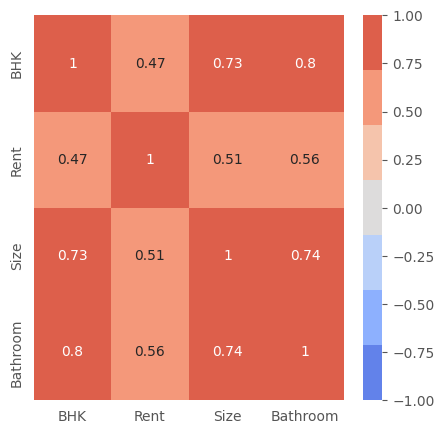

In [56]:
# Create correlation matrix
plt.figure(figsize=(5,5))
corr = df.select_dtypes(include="number").corr(method='pearson')

# plot correlation matrix using heatmap
sns.heatmap(corr, cmap=sns.color_palette('coolwarm', 7), annot=True, vmin=-1, vmax=1)

# show plot
plt.show()

## Feature Engineering

In [57]:
# Scale the column of "Size"

# initialize the MinMaxScaler
scaler = MinMaxScaler() # use the MinMaxScaler, hence the distribution of size is not normal

# fit and transform the "Size" column using MinMaxScaler
df['Size'] = scaler.fit_transform(df[['Size']])

# display the dataframe with changed column
df.tail()

,Posted On,BHK,Rent,Size,Floor,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
4741,2022-05-18,2,15000,0.141631,3 out of 5,Carpet Area,Hyderabad,Semi-Furnished,Bachelors/Family,2,Contact Owner
4742,2022-05-15,3,29000,0.284692,1 out of 4,Super Area,Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Owner
4743,2022-07-10,3,35000,0.248927,3 out of 5,Carpet Area,Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Agent
4744,2022-07-06,3,45000,0.213162,23 out of 34,Carpet Area,Hyderabad,Semi-Furnished,Family,2,Contact Agent
4745,2022-05-04,2,15000,0.141631,4 out of 5,Carpet Area,Hyderabad,Unfurnished,Bachelors,2,Contact Owner


In [58]:
# Display the "Floor" values
df['Floor'] = df['Floor'].astype('str')
df['Floor'].value_counts()

1 out of 2         377
Ground out of 2    350
2 out of 3         312
2 out of 4         308
1 out of 3         292
                  ... 
11 out of 31         1
50 out of 75         1
18 out of 26         1
12 out of 27         1
23 out of 34         1
Name: Floor, Length: 480, dtype: int64

In [59]:
# Extract floor placement and building floors from Floor column using regular expressions
df['Flat_floor'] = df['Floor'].str.extract(r'(\w+) out of')
df['Building_floors'] = df['Floor'].str.extract(r'out of (\w+)')

# check whether the above code find all floors properly
non_matching_rows = df[df['Flat_floor'].isnull()]
print(non_matching_rows)

      Posted On  BHK   Rent      Size   Floor    Area Type       City  \
2553 2022-06-18    2  20000  0.055794       3   Super Area      Delhi   
2883 2022-05-23    1  18000  0.062947  Ground  Carpet Area      Delhi   
4490 2022-06-12    3  15000  0.127325       1   Super Area  Hyderabad   
4560 2022-05-31    3  15000  0.180258       1  Carpet Area  Hyderabad   

     Furnishing Status  Tenant Preferred  Bathroom Point of Contact  \
2553       Unfurnished  Bachelors/Family         1    Contact Owner   
2883         Furnished  Bachelors/Family         1    Contact Owner   
4490    Semi-Furnished  Bachelors/Family         3    Contact Owner   
4560         Furnished            Family         2    Contact Owner   

     Flat_floor Building_floors  
2553        NaN             NaN  
2883        NaN             NaN  
4490        NaN             NaN  
4560        NaN             NaN  


In [60]:
# Drop Nan Values
df.dropna(inplace=True)

In [61]:
# Change the floor level to numerical values of str instances 
df['Flat_floor'] = np.where(df['Flat_floor'] == 'Ground', 0, df['Flat_floor'])
df['Flat_floor'] = np.where(df['Flat_floor'] == 'Basement', -1, df['Flat_floor'])

In [62]:
# Add two new variables - is flat on the top floor and is it on the ground one
df['Top_floor'] = 0
df['Top_floor'] = np.where(df['Flat_floor'] == df['Building_floors'], 1, df['Top_floor'])

df['Ground_floor'] = 0
df['Ground_floor'] = np.where(df['Flat_floor'] == 0, 1, df['Ground_floor'])

df['Flat_floor'] = df['Flat_floor'].astype(int)
df['Building_floors'] = df['Building_floors'].astype(int)

In [63]:
# Add a new column for the feature based on the date
df['Month posting time'] = df['Posted On'].apply(lambda x: 'beginning' if x.day <= 7 else 'middle' if x.day <= 21 else 'end')

In [64]:
# Create new variables based on the floor number, indciating the relative size of building

# calculate the quantile values
q1 = df['Building_floors'].quantile(0.1)
q2 = df['Building_floors'].quantile(0.3)
q3 = df['Building_floors'].quantile(0.7)
q4 = df['Building_floors'].quantile(0.9)
q5 = df['Building_floors'].quantile(1.0)

# create a function to assign the relative size category, based on the number of floors
def get_building_size(floors):
    if floors <= q1:
        return 'very_small'
    elif floors <= q2:
        return 'small'
    elif floors <= q3:
        return 'medium'
    elif floors <= q4:
        return 'large'
    else:
        return 'very_large'

# apply the function to create the "Building_Size" column
df['Building_Size'] = df['Building_floors'].apply(get_building_size)

# display the resulted dataframe
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Flat_floor,Building_floors,Top_floor,Ground_floor,Month posting time,Building_Size
0,2022-05-18,2,10000,0.155937,Ground out of 2,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2,0,1,middle,very_small
1,2022-05-13,2,20000,0.113019,1 out of 3,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3,0,0,middle,small
2,2022-05-16,2,17000,0.141631,1 out of 3,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,1,3,0,0,middle,small
3,2022-07-04,2,10000,0.113019,1 out of 2,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1,2,0,0,beginning,very_small
4,2022-05-09,2,7500,0.120172,1 out of 2,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner,1,2,0,0,middle,very_small


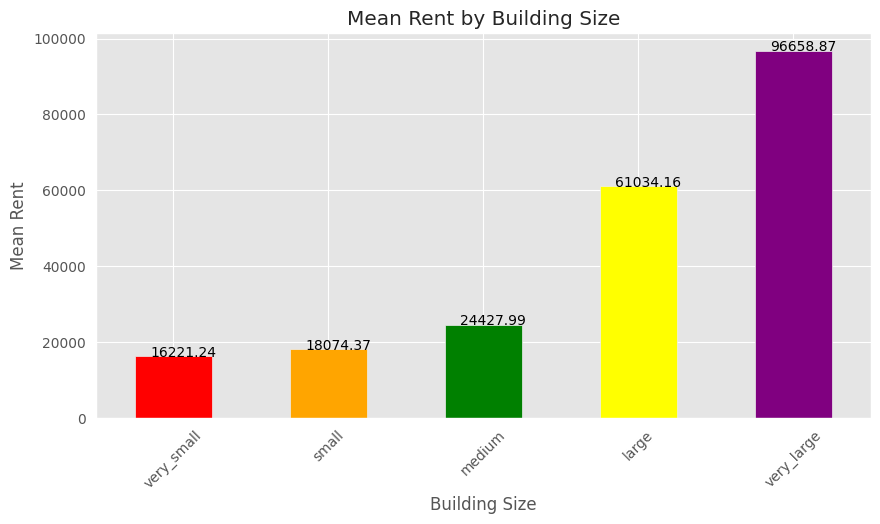

In [66]:
# Plot the rent by building size
plt.figure(figsize=(10,5))

# group the data by "Building_Size" and calculate the mean rent for each group
rent_by_size = df.groupby('Building_Size')['Rent'].mean()

# define the colors for each category
colours = ['red', 'orange', 'green', 'yellow', 'purple']

# define the order of the categories
order = ['very_small', 'small', 'medium', 'large', 'very_large']

# create a bar chart of the mean rents for each building size category
rent_by_size.loc[order].plot(kind='bar', color=colours)

# add the value of each bar above it
for i, v in enumerate(rent_by_size.loc[order]):
    plt.text(i - 0.15, v + 50, str(round(v, 2)), color='black')

# set the title and axis labels
plt.title('Mean Rent by Building Size')
plt.xlabel('Building Size')
plt.ylabel('Mean Rent')

# rotate the xticks by 45 degrees
plt.xticks(rotation=45)

# show the plot
plt.show()

# Initial training

### Preapring data

In [67]:
# Initial split into x and y
y = df['Rent']
X = df.copy()
X = X.drop('Rent', axis=1)
X = X.drop('Floor', axis=1)
X = X.drop('Posted On', axis=1)

### Feature Importance check

In [68]:
# Split categorical and numerical column dataframe
cat_X = X.select_dtypes(include=['object', 'datetime64[ns]'])
num_X = X.select_dtypes(exclude=['object', 'datetime64[ns]'])

# store the names of categorical and numerical columns
cat_features = list(cat_X.columns)
num_features = list(num_X.columns)

# create Ordinal Encoder object and fit it to the data
cat_transformer = OrdinalEncoder(handle_unknown='error')
cat_X = X.select_dtypes(include=['object', 'datetime64[ns]'])
X[cat_features] = cat_transformer.fit_transform(X[cat_features])

# define scaler for numerical features and apply it to the data
num_features = X.select_dtypes(include=['float', 'int']).columns
num_transformer = StandardScaler()
X[num_features] = num_transformer.fit_transform(X[num_features])

# fit Lasso Regression model
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)

# get feature importance
feature_importance = pd.Series(index=X.columns, data=lasso.coef_)
sorted_importance = feature_importance.abs().sort_values(ascending=False)

# print the feature importance in descending order
print(sorted_importance)

Size                  17883.829025
Bathroom              11804.352264
City                   9082.668086
Building_floors        8765.455634
Point of Contact       7071.619691
Flat_floor             4131.112256
Furnishing Status      3604.731563
Area Type              2147.808407
Month posting time     1108.109755
Ground_floor            413.857983
Top_floor               383.997688
Tenant Preferred        347.975261
Building_Size           326.464611
BHK                     306.012315
dtype: float64


In [69]:
# Save the names of the most important columns
sorted_importance_columns = sorted_importance.index.to_list()
sorted_importance_columns[:9] # showing 9 most important columns, with values over 1000

['Size',
 'Bathroom',
 'City',
 'Building_floors',
 'Point of Contact',
 'Flat_floor',
 'Furnishing Status',
 'Area Type',
 'Month posting time']

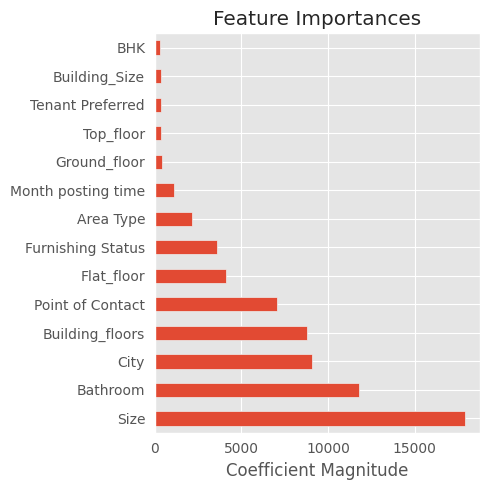

In [72]:
# Plot feature importances
fig, ax = plt.subplots(figsize=(5, 5))
sorted_importance.plot(kind='barh', ax=ax)
ax.set_title("Feature Importances")
ax.set_xlabel("Coefficient Magnitude")
plt.tight_layout()
plt.show()

## Base models training

In [73]:
# Create new X object
# X2 = X.copy() # uncomment for using this X (all features)
# X2 = X.loc[:, sorted_importance_columns[:9]] # uncomment for using this X (9 features)
X2 = X.loc[:, sorted_importance_columns[:5]] # uncomment for using this X (5 features)

In [74]:
# Split categorical and numerical column dataframe
cat_X = X.select_dtypes(include=['object', 'datetime64[ns]'])
num_X = X.select_dtypes(exclude=['object', 'datetime64[ns]'])

# store the names of categorical and numerical columns
cat_features = list(cat_X.columns)
num_features = list(num_X.columns)

# split data into training and test data (All features)
X_train, X_test, y_train, y_test = train_test_split(X2, y, random_state=33, train_size = .8)

In [75]:
# Prepare for pipeline training

# define column transformer for encoding categorical values
ct = ColumnTransformer([
    ('OrdinalEncoder', OrdinalEncoder(handle_unknown='error'), cat_features),
], remainder='passthrough')

# define scaler for numerical features
scaler = StandardScaler()

# define pipelines
pipe_lr = make_pipeline(ct, scaler, LinearRegression())

pipe_dtr = make_pipeline(ct, scaler, DecisionTreeRegressor(random_state=1))

pipe_gbr = make_pipeline(ct, scaler, GradientBoostingRegressor(random_state=1))

pipe_rf = make_pipeline(ct, scaler, RandomForestRegressor(random_state=1))

pipe_en = make_pipeline(ct, scaler, ElasticNet(random_state=1))

pipe_knn = make_pipeline(ct, scaler, KNeighborsRegressor())

pipe_gpr = make_pipeline(ct, scaler, GaussianProcessRegressor(random_state=1))

pipe_xgb = make_pipeline(ct, scaler, XGBRegressor(random_state=1))

# define hyperparameters to tune for each model
params_lr = {
    'linearregression__fit_intercept': [True, False],
}

params_dtr = {
    'decisiontreeregressor__max_depth': [5, 8, 10, 15, 20],
    'decisiontreeregressor__min_samples_split': [10, 15, 20],
    'decisiontreeregressor__min_samples_leaf': [4, 6, 8],
}

params_gbr = {
    'gradientboostingregressor__n_estimators': [50, 100],
    'gradientboostingregressor__max_depth': [2, 3, 5],
    'gradientboostingregressor__learning_rate': [0.01, 0.1, 1],
    'gradientboostingregressor__min_samples_split': [2, 5, 10],
}

params_rf = {
    'randomforestregressor__n_estimators': [50, 100],
    'randomforestregressor__max_depth': [8, 12, 20],
    'randomforestregressor__min_samples_split': [10, 15, 20],
    'randomforestregressor__min_samples_leaf': [2, 4, 6],
}

params_en = {
    'elasticnet__alpha': [0.05, 0.1, 0.15],
    'elasticnet__l1_ratio': [0.05, 0.1, 0.15],
    'elasticnet__max_iter': [100, 200],
}

params_knn = {
    'kneighborsregressor__n_neighbors': [8, 10, 12],
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__algorithm': ['ball_tree', 'kd_tree', 'brute'],
}

params_gpr = {
    'gaussianprocessregressor__alpha': [1e-3, 1e-2, 1e-1],
    'gaussianprocessregressor__n_restarts_optimizer': [0, 1, 2],
    'gaussianprocessregressor__normalize_y': [True, False],
}

params_xgb = {
    'xgbregressor__max_depth': [3, 5],
    'xgbregressor__learning_rate': [0.01, 0.1],
    'xgbregressor__n_estimators': [50, 100],
    'xgbregressor__reg_alpha': [0.6, 0.8, 1],
    'xgbregressor__reg_lambda': [0.1, 0.2, 0.5],
}

In [76]:
# Perform hyperparameter tuning for each model for all features training
grid_lr = GridSearchCV(pipe_lr, params_lr, cv=5, verbose=1)
grid_lr.fit(X_train, y_train)
print('Linear Regression model is compiled')

grid_dtr = GridSearchCV(pipe_dtr, params_dtr, cv=5, verbose=1)
grid_dtr.fit(X_train, y_train)
print('Decision Tree Regressor model is compiled')

grid_gbr = GridSearchCV(pipe_gbr, params_gbr, cv=5, verbose=1)
grid_gbr.fit(X_train, y_train)
print('Gradient Boosting Regressor model is compiled')

grid_rf = GridSearchCV(pipe_rf, params_rf, cv=5, verbose=1)
grid_rf.fit(X_train, y_train)
print('Random Forest Regressor model is compiled')

grid_en = GridSearchCV(pipe_en, params_en, cv=5, verbose=1)
grid_en.fit(X_train, y_train)
print('Elastic Net Regression model is compiled')

grid_knn = GridSearchCV(pipe_knn, params_knn, cv=5, verbose=1)
grid_knn.fit(X_train, y_train)
print('K-nearest Neighbors Regression model is compiled')

grid_gpr = GridSearchCV(pipe_gpr, params_gpr, cv=5, verbose=1)
grid_gpr.fit(X_train, y_train)
print('Gaussian Process Regression model is compiled')

grid_xgb = GridSearchCV(pipe_xgb, params_xgb, cv=5, verbose=1)
grid_xgb.fit(X_train, y_train)
print('XGBoosting Regression model is compiled')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Linear Regression model is compiled
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Decision Tree Regressor model is compiled
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Gradient Boosting Regressor model is compiled
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Random Forest Regressor model is compiled
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Elastic Net Regression model is compiled
Fitting 5 folds for each of 18 candidates, totalling 90 fits
K-nearest Neighbors Regression model is compiled
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Gaussian Process Regression model is compiled
Fitting 5 folds for each of 72 candidates, totalling 360 fits
XGBoosting Regression model is compiled


In [77]:
# Best paramters for each predictor
print('Best paramters for Linear Regression: ')
print(grid_lr.best_params_)
print('\n Best paramters for Decision Tree Regressor: ')
print(grid_dtr.best_params_)
print('\n Best paramters for Gradient Boosting Regressor: ')
print(grid_gbr.best_params_)
print('\n Best paramters for Random Forest Regressor: ')
print(grid_rf.best_params_)
print('\nBest parameters for Elastic Net Regression: ')
print(grid_en.best_params_)
print('\nBest parameters for K-nearest Neighbors Regression: ')
print(grid_knn.best_params_)
print('\nBest parameters for Gaussian Process Regression: ')
print(grid_gpr.best_params_)
print('\nBest parameters for XGBoosting Regression: ')
print(grid_xgb.best_params_)

Best paramters for Linear Regression: 
{'linearregression__fit_intercept': True}

 Best paramters for Decision Tree Regressor: 
{'decisiontreeregressor__max_depth': 10, 'decisiontreeregressor__min_samples_leaf': 6, 'decisiontreeregressor__min_samples_split': 15}

 Best paramters for Gradient Boosting Regressor: 
{'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__n_estimators': 100}

 Best paramters for Random Forest Regressor: 
{'randomforestregressor__max_depth': 8, 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__n_estimators': 50}

Best parameters for Elastic Net Regression: 
{'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.05, 'elasticnet__max_iter': 100}

Best parameters for K-nearest Neighbors Regression: 
{'kneighborsregressor__algorithm': 'brute', 'kneighborsregressor__n_neighbors': 8, '

In [78]:
# Evaluate the best estimator of each grid search object on the test data

print('Results of models: ')

# linear Regression
y_pred_lr = grid_lr.predict(X_test)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_lr = r2_score(y_test, y_pred_lr)
print("\n Linear Regression RMSE on the test data:", rmse_lr)
print("Linear Regression R2 on the test data:", r2_lr)

# decision Tree Regressor
y_pred_dtr = grid_dtr.predict(X_test)
rmse_dtr = mean_squared_error(y_test, y_pred_dtr, squared=False)
r2_dtr = r2_score(y_test, y_pred_dtr)
print("\n Decision Tree Regressor RMSE on the test data:", rmse_dtr)
print("Decision Tree Regressor R2 on the test data:", r2_dtr)

# gradient Boost Regressor
y_pred_gbr = grid_gbr.predict(X_test)
rmse_gbr = mean_squared_error(y_test, y_pred_gbr, squared=False)
r2_gbr = r2_score(y_test, y_pred_gbr)
print("\n Gradient Boosting Regressor RMSE on the test data:", rmse_gbr)
print("Gradient Boosting Regressor R2 on the test data:", r2_gbr)

# random Forest Regressor
y_pred_rf = grid_rf.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)
print("\n Random Forest Regressor RMSE on the test data:", rmse_rf)
print("Random Forest Regressor R2 on the test data:", r2_rf)

# elastic net regression
y_pred_en = grid_en.predict(X_test)
rmse_en = mean_squared_error(y_test, y_pred_en, squared=False)
r2_en = r2_score(y_test, y_pred_en)
print("\n Elastic Net Regression RMSE on the test data:", rmse_en)
print("Elastic Net Regression R2 on the test data:", r2_en)

# knn regression
y_pred_knn = grid_knn.predict(X_test)
rmse_knn = mean_squared_error(y_test, y_pred_knn, squared=False)
r2_knn = r2_score(y_test, y_pred_knn)
print("\n K-nearest Neighbors Regression RMSE on the test data:", rmse_knn)
print("K-nearest Neighbors Regression R2 on the test data:", r2_knn)

# gaussian process regression
y_pred_gpr = grid_gpr.predict(X_test)
rmse_gpr = mean_squared_error(y_test, y_pred_gpr, squared=False)
r2_gpr = r2_score(y_test, y_pred_gpr)
print("\n Gaussian Process Regression RMSE on the test data:", rmse_gpr)
print("Gaussian Process Regression R2 on the test data:", r2_gpr)

# XGBoosting regression
y_pred_xgb = grid_xgb.predict(X_test)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("\n XGBoosting Regression RMSE on the test data:", rmse_xgb)
print("XGBoosting Regression R2 on the test data:", r2_xgb)

Results of models: 

 Linear Regression RMSE on the test data: 37686.0310275481
Linear Regression R2 on the test data: 0.47451321418970793

 Decision Tree Regressor RMSE on the test data: 25992.82644699124
Decision Tree Regressor R2 on the test data: 0.7500184187460235

 Gradient Boosting Regressor RMSE on the test data: 23920.026182146587
Gradient Boosting Regressor R2 on the test data: 0.7882983230764709

 Random Forest Regressor RMSE on the test data: 23401.257721931554
Random Forest Regressor R2 on the test data: 0.7973813600126956

 Elastic Net Regression RMSE on the test data: 37543.46158722684
Elastic Net Regression R2 on the test data: 0.47848161540747414

 K-nearest Neighbors Regression RMSE on the test data: 25849.230112364046
K-nearest Neighbors Regression R2 on the test data: 0.7527728159749711

 Gaussian Process Regression RMSE on the test data: 25815.83664541639
Gaussian Process Regression R2 on the test data: 0.7534111669146465

 XGBoosting Regression RMSE on the test da

In [79]:
# Prepare resulted data for plotting

# define the models and their RMSE and R2 values
models = ['Linear Regression', 'Decision Tree Regressor', 'Gradient Boosting Regressor', 
          'Random Forest Regressor', 'Elastic Net Regression', 'K-nearest Neighbors Regression',
          'Gaussian Process Regression', 'XGBoosting Regression']
rmse_values = [rmse_lr, rmse_dtr, rmse_gbr, rmse_rf, rmse_en, rmse_knn, rmse_gpr, rmse_xgb]
r2_values = [r2_lr, r2_dtr, r2_gbr, r2_rf, r2_en, r2_knn, r2_gpr, r2_xgb]

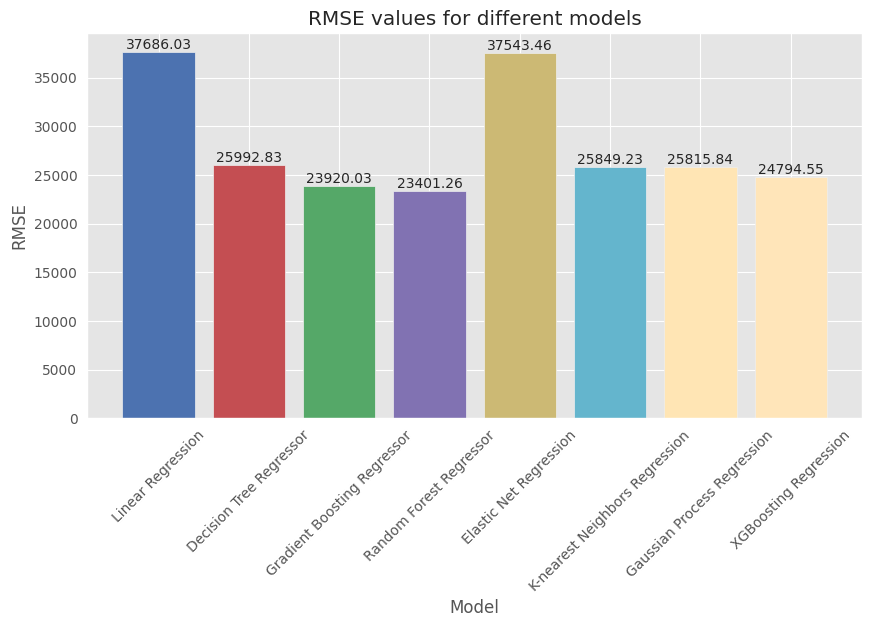

In [83]:
# Plot the results of RMSE for each model

# create a bar chart showing the RMSE values for each model
plt.figure(figsize=(10, 5))
bars = plt.bar(models, rmse_values, color=colors)

# set title and labels
plt.title('RMSE values for different models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

# add annotations to each bar
for bar, rmse in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width() / 2, rmse, f'{rmse:.2f}', ha='center', va='bottom')

# display the plot
plt.show()

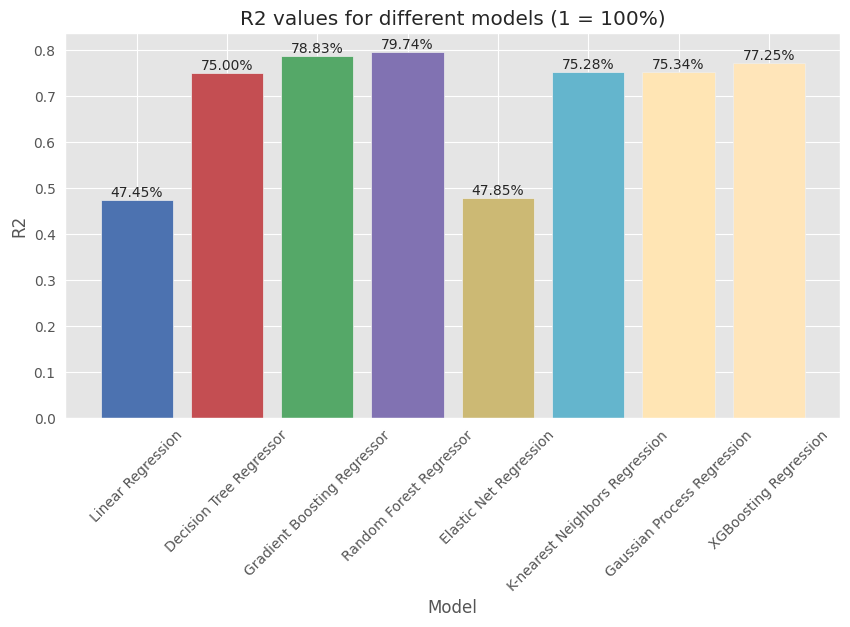

In [84]:
# Create a bar chart showing the R2 values for each model
plt.figure(figsize=(10, 5))
bars = plt.bar(models, r2_values, color=colors)

# set title and labels
plt.title('R2 values for different models (1 = 100%)')
plt.xlabel('Model')
plt.ylabel('R2')
plt.xticks(rotation=45)

# add annotations to each bar
for bar, r2 in zip(bars, r2_values):
    plt.text(bar.get_x() + bar.get_width() / 2, r2, f'{r2*100:.2f}%', ha='center', va='bottom')

# display the plot
plt.show()

## Note:
As Expected models, like Random Forest Regressor are not sensitive to the number of features, whereas models like K-nearst Neighbors are highly infulenced by them. As a result, after training models 3 times (with 14, 9, and 5 features), the best model is Random Forest Regressor with highest results, and adding features is not improving significantly the model performance. Nevertheless, all tree-based regression models obtaiend high accuracy. K-Nearest Neighbors obtained good result, after cutting variables to 5. Linear based models are not suitable for the task, with very low results. 

# Hybrid training

In [85]:
# Preapre data for hybrid model 

# Split categorical and numerical column dataframe
cat_X = X.select_dtypes(include=['object', 'datetime64[ns]'])
num_X = X.select_dtypes(exclude=['object', 'datetime64[ns]'])

# store the names of categorical and numerical columns
cat_features = list(cat_X.columns)
num_features = list(num_X.columns)

# split data into training and test data (All features)
X_train, X_test, y_train, y_test = train_test_split(X2, y, random_state=33, train_size = .8)

In [86]:
# Make a hybrid model

# define the column transformer
ct = ColumnTransformer([
    ('ordinal', OrdinalEncoder(), cat_features)
], remainder='passthrough')

# define the scaler
scaler = StandardScaler()

# define the models to be used in the ensemble
rf = RandomForestRegressor()
knn = KNeighborsRegressor()

# make a hybrid pipeline
pipe_hybrid = make_pipeline(ct, scaler, VotingRegressor(estimators=[
        ('rf', RandomForestRegressor(random_state=1)),
        ('knn', KNeighborsRegressor()),
    ]))

# specify the hyperparameter space
param_grid_hybrid = {
    'votingregressor__weights': [[1, 1], [2,1]],
    'votingregressor__rf__max_depth': [12, 15],
    'votingregressor__rf__min_samples_split': [12, 15],
    'votingregressor__knn__n_neighbors': [8, 10, 12],
    'votingregressor__knn__weights': ['uniform', 'distance'],
}

# perform the grid search
grid_search_hybrid = GridSearchCV(pipe_hybrid, param_grid_hybrid, cv=5, verbose=1)

In [87]:
# fit the grid search
grid_search_hybrid.fit(X_train, y_train)

# get the best estimator
best_hybrid_model = grid_search_hybrid.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [89]:
best_hybrid_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal', OrdinalEncoder(),
                                                  [])])),
                ('standardscaler', StandardScaler()),
                ('votingregressor',
                 VotingRegressor(estimators=[('rf',
                                              RandomForestRegressor(max_depth=12,
                                                                    min_samples_split=12,
                                                                    random_state=1)),
                                             ('knn',
                                              KNeighborsRegressor(n_neighbors=8))],
                                 weights=[2, 1]))])

In [88]:
# Evaluate the hybrid model
y_predicted_hybrid = best_hybrid_model.predict(X_test)
rmse_hybrid = mean_squared_error(y_test, y_predicted_hybrid, squared=False)
r2_hybrid = r2_score(y_test, y_predicted_hybrid)
print("\n Hybrid model RMSE on the test data:", rmse_hybrid)
print("Hybrid model R2 on the test data:", r2_hybrid)


 Hybrid model RMSE on the test data: 23439.573661718186
Hybrid model R2 on the test data: 0.7967173034490485


# The comparision between models

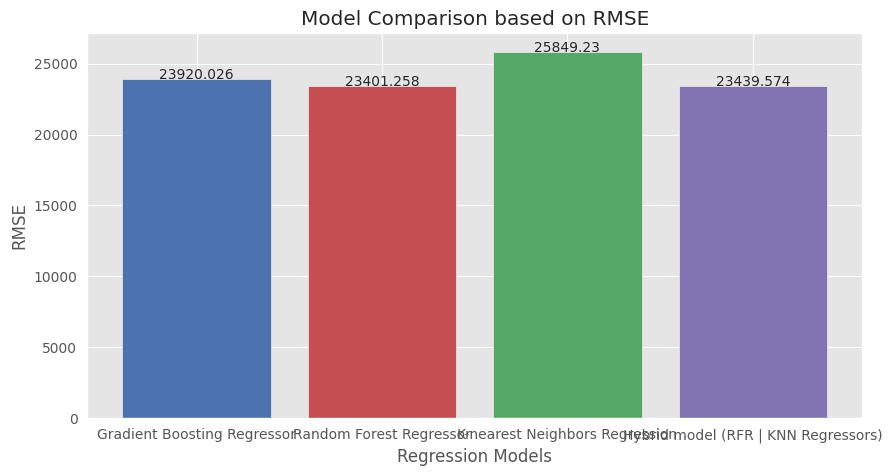

In [90]:
# Show the diffrence between models and their accuracy RMSE
plt.figure(figsize=(10, 5))

# create a dictionary with results of few chosen models
final_results_rmse = {'Gradient Boosting Regressor' : rmse_gbr,
                      'Random Forest Regressor' : rmse_rf,
                      'K-nearest Neighbors Regression' : rmse_knn,
                      'Hybrid model (RFR | KNN Regressors)' : rmse_hybrid}

# create a bar plot with the RMSE values
plt.bar(final_results_rmse.keys(), final_results_rmse.values(), color=colors)

# add annotations above each bar with their corresponding RMSE value
for i, v in enumerate(final_results_rmse.values()):
    plt.text(i, v, str(round(v, 3)), ha='center')

# set title, labels and show the plot
plt.title('Model Comparison based on RMSE')
plt.xlabel('Regression Models')
plt.ylabel('RMSE')
plt.show()

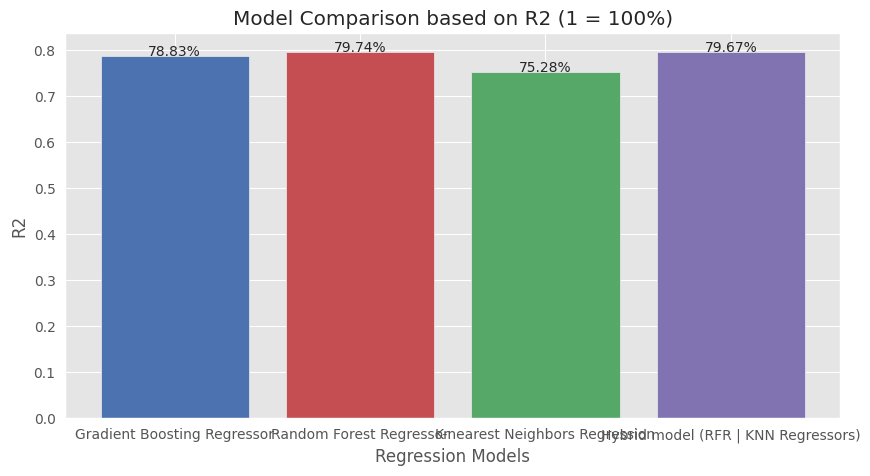

In [91]:
# Show the diffrence between models and their accuracy RMSE
plt.figure(figsize=(10, 5))

# create a dictionary with results of few chosen models
final_results_r2 = {'Gradient Boosting Regressor' : r2_gbr,
                      'Random Forest Regressor' : r2_rf,
                      'K-nearest Neighbors Regression' : r2_knn,
                      'Hybrid model (RFR | KNN Regressors)' : r2_hybrid}

# create a bar plot with the RMSE values
plt.bar(final_results_r2.keys(), final_results_r2.values(), color=colors)

# add annotations above each bar with their corresponding RMSE value
for i, v in enumerate(final_results_r2.values()):
    plt.text(i, v, str(round(v * 100, 2)) + '%', ha='center')

# set title, labels and show the plot
plt.title('Model Comparison based on R2 (1 = 100%)')
plt.xlabel('Regression Models')
plt.ylabel('R2')
plt.show()

## Final Note:
The results indicate that Random Forest Regressor (RFR) is once again the best model, however the diffrence between it and the next - hybrid model is unsignificant (around 0.07 % of R2). Moreover, the Gradient Boosting Regressor is also very capable for the task. Furthermore, if there is a need for non-tree based model, the K-nearest Neighbors Regression achieved also relatievly good results, however it is adviced to be careful with the numer of features input in this model. On contrary, RFR with all features achieved slightly better results (around 80.1 %), however model compilation is longer. Finally, the linear-based models are not suitable for the task, getting very low results.

The choice of the model depends on the preferences and possible application, the hybrid model in the above research form is not scoring better than the component - RFR. 